# Cassava Leaf-Disease Identification - EDA cum Image Processing

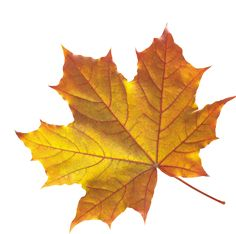

This book composes of initial **Exploratory Data Analysis(EDA) and Image Processing techniques** that could be employed in the analysis of images, in such competitions. Apart from the competiton dataset, I also used a metadata file from : 

**https://www.kaggle.com/fireheart7/cassavaimagestatistics** 

This file encapsulates **pre-compiled statistics for every image in our training set**. If you wish to check on how this metadata is compiled, it's available at : 

**https://www.kaggle.com/fireheart7/cassava-metadata-preparation**

The notebook is still under work, but a significant portion is ready for sharing with the community. Hope you all find it useful here, and in the future competitons.


*All the best and let's dive straight in!*

Load important dependencies!

In [ ]:
import os
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
%matplotlib inline
from tqdm.notebook import tqdm # for progress bar

import cv2
import albumentations as A

In [ ]:
train = pd.DataFrame(pd.read_csv("../input/cassava-leaf-disease-classification/train.csv"))

print("Shape of dataframe = ", train.shape)

In [ ]:
train.head()

In [ ]:
train.info()

So, yes no missing labels. We have a complete dataset.

In [ ]:
PATH_TRAIN_IMAGES = "../input/cassava-leaf-disease-classification/train_images/" 

Now, we will define `load_image( )` function which will take the name of the image to be loaded as input from the base directory, and returns the image.

*Note that **openCV** reads image in BGR format by default. Hence, post loading it ought be converted into RGB format*.

In [ ]:
def load_image(base_path, image_name) : 
    image_path = base_path + image_name
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

We will define a **resizing( )** function which will resize any image passed to it, according to our desired shape.

In [ ]:
def resize(image, image_size) : 
    image = cv2.resize(image, (image_size[0], image_size[1]), interpolation = cv2.INTER_AREA)
    return image

# Load Some Images : 

We will randomly sample 4 images from our training data folder, using **numpy.random.choice( )** module.

In [ ]:
random_images = [np.random.choice(os.listdir(PATH_TRAIN_IMAGES)) for i in range(4)]
random_images

In [ ]:
plt.figure(figsize = (12, 8))
for i in range(4) : 
    plt.subplot(2, 2, i+1)
    plt.title("Sampled Image {}".format(i + 1))
    image = load_image(PATH_TRAIN_IMAGES, random_images[i])
    plt.imshow(image, cmap = "gray")
    plt.grid(True)
    
# Automatically adjust subplot parameters to give specified padding.
plt.tight_layout()

# A Quick Look At The Need Of EDA : 

When we’re getting started with a machine learning (ML) project, one critical principle to keep in mind is that data is everything. It is often said that if ML is the rocket engine, then the fuel is the (high-quality) data fed to ML algorithms. However, deriving truth and insight from a pile of data can be a complicated and error-prone job. To have a solid start for our ML project, it always helps to analyze the data up front.

During EDA, it’s important that we get a deep understanding of:

* The properties of the data, such as schema and statistical properties;
* The quality of the data, like missing values and inconsistent data types;
* The predictive power of the data, such as correlation of features against target.

# Class Count Distribution : 

Let's count the various classes we have in our dataset. 

In [ ]:
d = dict()
for label in tqdm(train["label"].values) : 
    if label not in d : 
        d[label] = 1
    else:
        d[label] += 1

print(d)

In [ ]:
labels = ["Class0", "Class1", "Class2", "Class3"]
counts = [d[0], d[1], d[2], d[3]]

explode = (0.05, 0.05, 0.05, 0.05)
fig, ax = plt.subplots(figsize = (15, 12))
ax.pie(counts, explode = explode, labels = labels, shadow = True, startangle = 90)
ax.axis("equal")

**Inference** : 

* Class3 is quite in abundance. The dataset is **heavily skewed** when analuzed from class distribution perspective. **This is the popular class imbalance problem**. We will address this problem when in preprocessing segment.
* Class0 has the least presence in the overall distribution.
* Classes 1 and 2 have comparable presence.

# Analysing the color channel distribution in each Image

We know that upon diving deeper into an image, we find that **it is actually a 3-D tensor**, which is a fancy way of saying that it is multiple grids stacked one behind the other. Each grid correspond to one color channel. Hence, in a RGB image, we have three such grids(**a grid is also called a 2-D tensor**) corresponding to **Red, Green and Blue** color channels.

An illustration: 

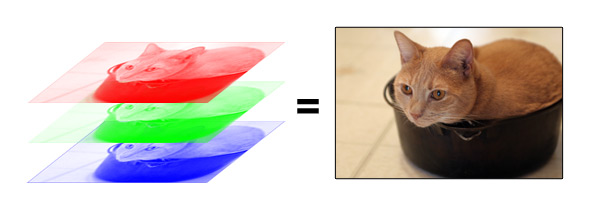

Note that it is actually the stacking of three channels, that collectively make up the final image we see.

So, we have images in **4 classes**, hence, we try to analyze the RGB spread of each class. 

**So, what's the point you may ask?**

*It's simple. It might happen that their spreads may give us some info on how to segregate/identify them. For example, it may happen that class0 red channel spread is highly negatively skewed, while that of class1 is high positive. So, this is a stong feature in order to distinguish between class0 and class1 image*. 

Let's see how the story unfolds :)

In [ ]:
image_ids = train["image_id"].values
labels = train["label"].values

red_spread = dict()
green_spread = dict()
blue_spread = dict()

for image_id, label in tqdm(zip(image_ids, labels)) : 
    image = load_image(PATH_TRAIN_IMAGES, image_id)
    mean_red = np.mean(image[:,:, 0])
    mean_green = np.mean(image[:, :, 1])
    mean_blue = np.mean(image[:, :, 2])
        
    if label not in red_spread : # since we are appending in all three dictionaries together, so if label is not in one of them, it won't be in the rest of them too.
        red_spread[label] = [mean_red]
        green_spread[label] = [mean_green]
        blue_spread[label] = [mean_blue]
    else:
        red_spread[label].append(mean_red)
        green_spread[label].append(mean_green)
        blue_spread[label].append(mean_blue)

## Skewness in EDA :

Skewness is the measure of symmetry or asymmetry of a data distribution. A distribution or data set is said to be symmetric if it looks same to the left and right point of the center.

Types of Skewness :

Skewness is generally classified into 2 broad categories-

* Right skewness or Positive skewness
* Left skewness or Negative skewness

It is very difficult to interpret and analyse the data which is skewed.

**Red Channel Analysis for ALL Classes**

In [ ]:
# red

plt.figure(figsize = (20, 12))

plt.subplot(2,2,1)
plt.title("Red Channel Analysis = Class 0", fontsize = 18)
plt.rc('font', weight='bold')
sns.set_style("whitegrid")
fig = sns.distplot(red_spread[0], hist = True, kde = True, label = "Class0 red channel intensities", color = "r")
fig.set(xlabel = "Mean Red Channel Intensities Observed For Each Image", ylabel = "Probability Density")
plt.grid(True)
plt.legend()

plt.subplot(2,2,2)
plt.title("Red Channel Analysis = Class 1", fontsize = 18)
plt.rc('font', weight='bold')
sns.set_style("whitegrid")
fig = sns.distplot(red_spread[1], hist = True, kde = True, label = "Class1 red channel intensities", color = "r")
fig.set(xlabel = "Mean Red Channel Intensities Observed For Each Image", ylabel = "Probability Density")
plt.grid(True)
plt.legend()

plt.subplot(2,2,3)
plt.title("Red Channel Analysis = Class 2", fontsize = 18)
plt.rc('font', weight='bold')
sns.set_style("whitegrid")
fig = sns.distplot(red_spread[2], hist = True, kde = True, label = "Class2 red channel intensities", color = "r")
fig.set(xlabel = "Mean Red Channel Intensities Observed For Each Image", ylabel = "Probability Density")
plt.grid(True)
plt.legend()

plt.subplot(2,2,4)
plt.title("Red Channel Analysis = Class 3", fontsize = 18)
plt.rc('font', weight='bold')
sns.set_style("whitegrid")
fig = sns.distplot(red_spread[3], hist = True, kde = True, label = "Class3 red channel intensities", color = "r")
fig.set(xlabel = "Mean Red Channel Intensities Observed For Each Image", ylabel = "Probability Density")
plt.grid(True)
plt.legend()

plt.tight_layout()

print("Mean and Standard deviation for class 0 = {}, {}".format(np.mean(red_spread[0]), np.std(red_spread[0])))
print("Mean and Standard deviation for class 1 = {}, {}".format(np.mean(red_spread[1]), np.std(red_spread[1])))
print("Mean and Standard deviation for class 2 = {}, {}".format(np.mean(red_spread[2]), np.std(red_spread[2])))
print("Mean and Standard deviation for class 3 = {}, {}".format(np.mean(red_spread[3]), np.std(red_spread[3])))

**Green Channel Analysis For ALL Classes**

In [ ]:
# green

plt.figure(figsize = (20, 12))

plt.subplot(2,2,1)
plt.title("Green Channel Analysis = Class 0", fontsize = 18)
plt.rc('font', weight='bold')
sns.set_style("whitegrid")
fig = sns.distplot(green_spread[0], hist = True, kde = True, label = "Class0 green channel intensities", color = "g")
fig.set(xlabel = "Mean Green Channel Intensities Observed For Each Image", ylabel = "Probability Density")
plt.grid(True)
plt.legend()

plt.subplot(2,2,2)
plt.title("Green Channel Analysis = Class 1", fontsize = 18)
plt.rc('font', weight='bold')
sns.set_style("whitegrid")
fig = sns.distplot(green_spread[1], hist = True, kde = True, label = "Class1 green channel intensities", color = "g")
fig.set(xlabel = "Mean Green Channel Intensities Observed For Each Image", ylabel = "Probability Density")
plt.grid(True)
plt.legend()

plt.subplot(2,2,3)
plt.title("Green Channel Analysis = Class 2", fontsize = 18)
plt.rc('font', weight='bold')
sns.set_style("whitegrid")
fig = sns.distplot(green_spread[2], hist = True, kde = True, label = "Class2 green channel intensities", color = "g")
fig.set(xlabel = "Mean Green Channel Intensities Observed For Each Image", ylabel = "Probability Density")
plt.grid(True)
plt.legend()

plt.subplot(2,2,4)
plt.title("Green Channel Analysis = Class 3", fontsize = 18)
plt.rc('font', weight='bold')
sns.set_style("whitegrid")
fig = sns.distplot(green_spread[3], hist = True, kde = True, label = "Class3 green channel intensities", color = "g")
fig.set(xlabel = "Mean Green Channel Intensities Observed For Each Image", ylabel = "Probability Density")
plt.grid(True)
plt.legend()

plt.tight_layout()

print("Mean and Standard deviation for class 0 = {}, {}".format(np.mean(green_spread[0]), np.std(green_spread[0])))
print("Mean and Standard deviation for class 1 = {}, {}".format(np.mean(green_spread[1]), np.std(green_spread[1])))
print("Mean and Standard deviation for class 2 = {}, {}".format(np.mean(green_spread[2]), np.std(green_spread[2])))
print("Mean and Standard deviation for class 3 = {}, {}".format(np.mean(green_spread[3]), np.std(green_spread[3])))

**Blue Channel Analysis For ALL Classes**

In [ ]:
# blue

plt.figure(figsize = (20, 12))

plt.subplot(2,2,1)
plt.title("Blue Channel Analysis = Class 0", fontsize = 18)
plt.rc('font', weight='bold')
sns.set_style("whitegrid")
fig = sns.distplot(blue_spread[0], hist = True, kde = True, label = "Class0 blue channel intensities", color = "b")
fig.set(xlabel = "Mean Blue Channel Intensities Observed For Each Image", ylabel = "Probability Density")
plt.grid(True)
plt.legend()

plt.subplot(2,2,2)
plt.title("Blue Channel Analysis = Class 1", fontsize = 18)
plt.rc('font', weight='bold')
sns.set_style("whitegrid")
fig = sns.distplot(blue_spread[1], hist = True, kde = True, label = "Class1 blue channel intensities", color = "b")
fig.set(xlabel = "Mean Blue Channel Intensities Observed For Each Image", ylabel = "Probability Density")
plt.grid(True)
plt.legend()

plt.subplot(2,2,3)
plt.title("Blue Channel Analysis = Class 2", fontsize = 18)
plt.rc('font', weight='bold')
sns.set_style("whitegrid")
fig = sns.distplot(blue_spread[2], hist = True, kde = True, label = "Class2 blue channel intensities", color = "b")
fig.set(xlabel = "Mean Blue Channel Intensities Observed For Each Image", ylabel = "Probability Density")
plt.grid(True)
plt.legend()

plt.subplot(2,2,4)
plt.title("Blue Channel Analysis = Class 3", fontsize = 18)
plt.rc('font', weight='bold')
sns.set_style("whitegrid")
fig = sns.distplot(blue_spread[3], hist = True, kde = True, label = "Class3 blue channel intensities", color = "b")
fig.set(xlabel = "Mean Blue Channel Intensities Observed For Each Image", ylabel = "Probability Density")
plt.grid(True)
plt.legend()

plt.tight_layout()

print("Mean and Standard deviation for class 0 = {}, {}".format(np.mean(blue_spread[0]), np.std(blue_spread[0])))
print("Mean and Standard deviation for class 1 = {}, {}".format(np.mean(blue_spread[1]), np.std(blue_spread[1])))
print("Mean and Standard deviation for class 2 = {}, {}".format(np.mean(blue_spread[2]), np.std(blue_spread[2])))
print("Mean and Standard deviation for class 3 = {}, {}".format(np.mean(blue_spread[3]), np.std(blue_spread[3])))

## Inference : 

**RED Spread** : 
* The red spread cannot be considered as a distinguishing property as for all classes, it is nearly normal.

**Green Spread** :
* In terms of skweness, green spread's skewness also isn't a powerful factor to distinguish amongst classes.

**Blue Spread** : 
* In terms of skweness, blue spread's skewness also isn't a powerful factor to distinguish amongst classes.

**Couple Of Other Insights** : 
* The **mean value for class0 images** (be it any color channel in RGB) is the lowest among all other classes.
* The **standard deviation for class1 images** (be it any color channel in RGB) is the highest among all other classes.

# Load Additional Data For Further EDA

For this, I prepared additional metadata containing compiled statistics of all training images. 

Dataset : **https://www.kaggle.com/fireheart7/cassavaimagestatistics**

In [ ]:
train_image_statistics = pd.DataFrame(pd.read_csv("../input/cassavaimagestatistics/train_image_statistics.csv"))

print("Shape of metadata file = ", train_image_statistics.shape)

In [ ]:
train_image_statistics.head()

# Shape Analysis

In [ ]:
x = train_image_statistics["rows"]
y = train_image_statistics["columns"]

plt.figure(figsize = (12, 8))
plt.subplot(1,1,1)
plt.scatter(x, y, cmap = "magma")
plt.title("Shape Analysis Of Training Images", fontsize = 18)
plt.xlabel("Number of Rows", fontsize = 16)
plt.ylabel("Numbe of Columns", fontsize = 16)
plt.grid(True)
plt.minorticks_on()
plt.grid(which = "major", linestyle = "-", linewidth = '1.0', color = "grey")
plt.grid(which = "minor", linestyle = ":", linewidth = '0.5', color = "black")
plt.tight_layout()

So, all images have the same shape - that's kinda great!! Shape = **600 X 800**.

In [ ]:
fig = go.Figure(data = [go.Scatter3d(x = train_image_statistics["image_mean"], 
                                    y = train_image_statistics["image_sd"],
                                    z = train_image_statistics["image_skewness"],
                                    mode = "markers",
                                    marker = dict(size = 4, color = train_image_statistics["rows"],
                                                 colorscale = "jet", opacity = 0.4))],
               layout = go.Layout(margin = dict(l = 0, r = 0, b = 0, t = 0),
                                 scene = dict(xaxis = dict(title = "image_mean"),
                                             yaxis = dict(title = "image_sd"),
                                             zaxis = dict(title = "image_skewness"),),))
fig.show()

While a healthy bunch is clustered together, however we do see potential outliers that **fall way outside the big green cluster**. 

In data cleansing endeavour we might discard these paticular images.

# Image Denoising

Many image smoothing techniques like Gaussian Blurring, Median Blurring etc were **good to some extent in removing small quantities of noise**. In those techniques, *we took a small neighbourhood around a pixel and performed some operations like gaussian weighted average, median of the values etc to replace the central element. In short, noise removal at a pixel was local to its neighbourhood*.

**There is a property of noise. Noise is generally considered to be a random variable with zero mean**.

Suppose we hold a static camera to a certain location for a couple of seconds. This will give us plenty of frames, or a lot of images of the same scene. Then averaging all the frames, we compare the final result and first frame. **Reduction in noise would be easily observed**.

So idea is simple, we need a set of similar images to average out the noise. Considering a small window (say 5x5 window) in the image, chance is large that the same patch may be somewhere else in the image. Sometimes in a small neighbourhood around it. Hence, using these similar patches together averaging them can lead to an efficient denoised image.

**This method is Non-Local Means Denoising**. It takes more time compared to blurring techniques, but the result are very satisfying.

Denoising illustration :

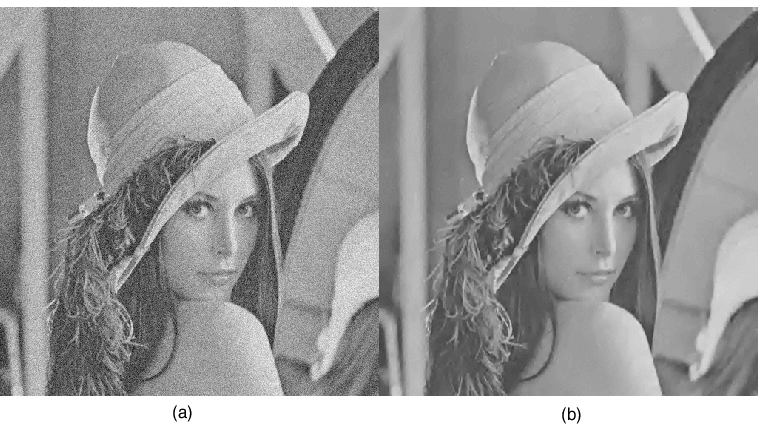

## OpenCV implementation of the aforementioned approach :

* **cv2.fastNlMeansDenoisingColored()** - Works on Colored images. 
* **cv2.fastNlMeansDenoising()** - Works on grayscale images.

Common arguments are:

* **h** : parameter deciding filter strength. Higher h value removes noise better, but removes details of image also. (10 is ok). 
* **hForColorComponents** : same as h, but for color images only. (normally same as h). 
* **templateWindowSize** : should be odd. (recommended 7). 
* **searchWindowSize** : should be odd. (recommended 21).

In [ ]:
def non_local_means_denoising(image) : 
    denoised_image = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
    return denoised_image

We had loaded some random images previously. Let's select one as our *sample_image* and perform all preprocessing ops on it.

In [ ]:
plt.figure(figsize = (20, 12))
sample_image = load_image(PATH_TRAIN_IMAGES, random_images[0])
plt.imshow(sample_image, cmap = "gray")
plt.grid(False)
plt.title("Sample Image", fontsize = 18)
plt.axis("off")

In [ ]:
denoised_image = non_local_means_denoising(sample_image)

plt.figure(figsize = (12, 8))
plt.subplot(1,2,1)
plt.imshow(sample_image, cmap = "gray")
plt.grid(False)
plt.title("Normal Image")

plt.subplot(1,2,2)  
plt.imshow(denoised_image, cmap = "gray")
plt.grid(False)
plt.title("Denoised image")    
# Automatically adjust subplot parameters to give specified padding.
plt.tight_layout()

Observe carefully. You will nitice the differences at various regions.

# Edge detection Using Sobel filter :

Edge detection is one of the fundamental operation in image processing. Using this, we can reduce the amount of pixels while maintaining the structural aspect of the images.

The basic operation involved behind edge detection is called Convolution and is illustrated below :

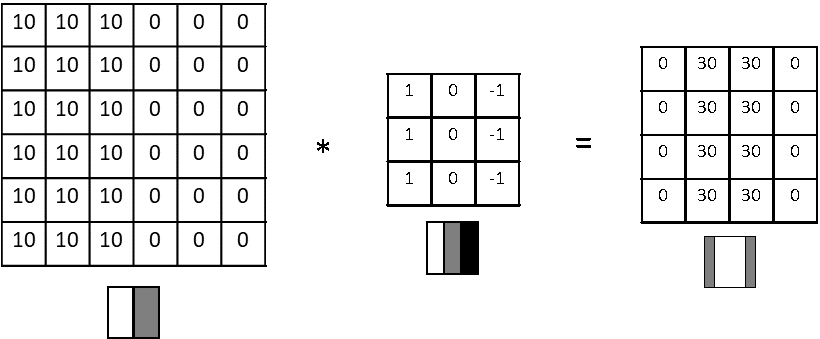

Edges can be detected using various kinds of filters.

* First derivative based Sobel filter(for thicker edges).
* Second derivative based Laplacian filter(for finer edges).

Here, we want to consider the area containing only the leaf, while ignoring the background green. Hence, we use Sobel filter to identify the prominent edge of the leaf.

**Using Sobel filter**

Sobel filter takes the following arguments : 
1. Original Image
2. Depth of the destination image
3. Order of derivative x
4. Order of derivative y
5. Kernel size for convolutions

**f(Image, depth, order_dx, order_dy, kernel_size)** 

In [ ]:
def sobel_edge_detection(image):
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize = 5)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize = 5)
    return sobel_x, sobel_y

In [ ]:
s_img_x, s_img_y = sobel_edge_detection(denoised_image)

plt.figure(figsize = (12, 8))
plt.subplot(2,2,1)
plt.imshow(sample_image, cmap = "gray")
plt.grid(False)
plt.title("Sample Image", fontsize = 18)

plt.subplot(2,2,2)
plt.imshow(denoised_image, cmap = "gray")
plt.grid(False)
plt.title("Denoised Image", fontsize = 18)

plt.subplot(2,2,3)
plt.imshow(s_img_x, cmap = "gray")
plt.grid(False)
plt.title("Sobel X filtered Image", fontsize = 18)

plt.subplot(2,2,4)
plt.imshow(s_img_y, cmap = "gray")
plt.grid(False)
plt.title("Sobel Y filtered Image", fontsize = 18)

# Automatically adjust subplot parameters to give specified padding.
plt.tight_layout()

# Canny Edge Detector :

The Canny filter is a multi-stage edge detector. It uses a filter based on the derivative of a Gaussian in order to compute the intensity of the gradients.The Gaussian reduces the effect of noise present in the image. Then, potential edges are thinned down to 1-pixel curves by removing non-maximum pixels of the gradient magnitude. Finally, edge pixels are kept or removed using hysteresis thresholding on the gradient magnitude.

The Canny has three adjustable parameters: the width of the Gaussian (the noisier the image, the greater the width), and the low and high threshold for the hysteresis thresholding.

The Canny edge detection algorithm is composed of 5 steps:

* Noise reduction;
* Gradient calculation;
* Non-maximum suppression;
* Double threshold;
* Edge Tracking by Hysteresis.


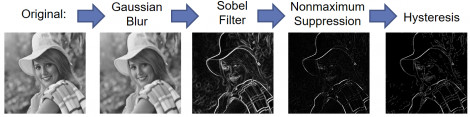

## Noise Reduction :

One way to get rid of the noise on the image, is by applying Gaussian blur to smooth it. To do so, image convolution technique is applied with a Gaussian Kernel (3x3, 5x5, 7x7 etc…). The kernel size depends on the expected blurring effect. Basically, the smallest the kernel, the less visible is the blur.

## Gradient Calculation :

The Gradient calculation step detects the edge intensity and direction by calculating the gradient of the image using edge detection operators. **The result is almost the expected one, but we can see that some of the edges are thick and others are thin. Non-Max Suppression step will help us mitigate the thick ones**.

## Non-Maximum Supression :

Ideally, **the final image should have thin edges. Thus, we must perform non-maximum suppression to thin out the edges**.

## Double Threshold :

The double threshold step aims at **identifying 3 kinds of pixels: strong, weak, and non-relevant**.

* `Strong pixels` are pixels that have an intensity so high that we are sure they contribute to the final edge.

* `Weak pixels` are pixels that have an intensity value that is not enough to be considered as strong ones, but yet not small enough to be considered as non-relevant for the edge detection.

* Other pixels are considered as non-relevant for the edge.

Therefore, the significance of having **two values in double threshold** :

* **High threshold is used to identify the strong pixels (intensity higher than the high threshold)**.

* **Low threshold is used to identify the non-relevant pixels (intensity lower than the low threshold)**.

**All pixels having intensity between both thresholds are flagged as weak and the Hysteresis mechanism (next step) will help us identify the ones that could be considered as strong and the ones that are considered as non-relevant.

## Hysteresis :

Based on the threshold results, **the hysteresis consists of transforming weak pixels into strong ones, if and only if at least one of the pixels around the one being processed is a strong one**.

We will be using OpenCV's implementation of Canny edge detection. This was the theory involved behind the entire process.

Further information can be found on OpenCV's documentation : https://docs.opencv.org/trunk/da/d22/tutorial_py_canny.html

In [ ]:
def canny_edge_detection(image) : 
    edges = cv2.Canny(image, 170, 200)
    return edges

In [ ]:
plt.figure(figsize = (12, 8))
plt.subplot(1,2,1)
plt.imshow(sample_image, cmap = "gray")
plt.grid(False)
plt.title("Sample Image", fontsize = 18)

edge_image = canny_edge_detection(sample_image) 

plt.subplot(1,2,2)
plt.imshow(edge_image, cmap = "gray")
plt.grid(False)
plt.title("Canny Edge Image", fontsize = 18)
# Automatically adjust subplot parameters to give specified padding.
plt.tight_layout()

# Histogram Equalization : 

First of all, why can we not apply histogram equalization directly to an RGB image?

Histogram equalization is a non-linear process. Channel splitting and equalizing each channel separately is **incorrect**. **Equalization involves intensity values of the image, not the color components**. 

So for a simple RGB color image, histogram equalization cannot be applied directly on the channels. **It needs to be applied in such a way that the intensity values are equalized without disturbing the color balance of the image**. 

* So, the **first step** is to convert the color space of the image from RGB into one of the color spaces that separates intensity values from color components. Some of the possible options are HSV/HLS, YUV, YCbCr, etc. YCbCr is preferred as it is designed for digital images. 

* **Perform histogram equalization on the intensity plane Y**. 
* Now **convert** the resultant YCbCr image back to RGB.

(Excerpt taken from :

https://prateekvjoshi.com/2013/11/22/histogram-equalization-of-rgb-images/ )

In [ ]:
def histogram_equalization(image) : 
    image_ycrcb = cv2.cvtColor(image, cv2.COLOR_RGB2YCR_CB)
    y_channel = image_ycrcb[:, :, 0] # apply histogram equalization here
    cr_channel = image_ycrcb[:, :, 1]
    cb_channel = image_ycrcb[:, :, 2]
    
    # local histogram equalization
    clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize = (8, 8))
    equalized = clahe.apply(y_channel)
    equalized_image = cv2.merge([equalized, cr_channel, cb_channel])
    equalized_image = cv2.cvtColor(equalized_image, cv2.COLOR_YCR_CB2RGB)
    return equalized_image

In [ ]:
equalized_denoised_image = histogram_equalization(denoised_image)

plt.figure(figsize = (12, 8))
plt.subplot(1,2,1)
plt.imshow(denoised_image, cmap = "gray")
plt.grid(False)
plt.title("de-Noised Image", fontsize = 18)

plt.subplot(1,2,2)
plt.imshow(equalized_denoised_image, cmap = "gray")
plt.grid(False)
plt.title("Histogram Equalized de-Noised Image", fontsize = 18)  
# Automatically adjust subplot parameters to give specified padding.
plt.tight_layout()

Observe the change in gray values/intensities in the second image. That's the result of **local histogram equalization**.

# Image Segmentation(Half-Toned Images) : Otsu's Binarization

In global thresholding, we used an arbitrary chosen value as a threshold. In contrast, Otsu's method avoids having to choose a value and determines it automatically.

We will apply Otsu's binarization segmentation method on the histogram equalized image obtained in the previous stage.

In [ ]:
otsu_threshold, otsu_image = cv2.threshold(cv2.cvtColor(equalized_denoised_image, cv2.COLOR_RGB2GRAY), 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.figure(figsize = (12, 8))
plt.subplot(1,2,1)
plt.imshow(equalized_denoised_image, cmap = "gray")
plt.grid(False)
plt.title("equalized de Noised Image", fontsize = 18)

plt.subplot(1,2,2)
plt.imshow(otsu_image, cmap = "gray")
plt.grid(False)
plt.title("Otsu's Thresholded Image", fontsize = 18)  
# Automatically adjust subplot parameters to give specified padding.

plt.tight_layout()

Thank you for reading this far!

# A Look Into Disease Names :

We have been provided with a **.json** file mapping the numeric labels to disease names. Let's have a look at disease names.

**Little Insight Into JSON(Javascript Object Notation)** :
JSON is a script (executable) file which is made of text in a programming language, **is used to store and transfer the data**. Python supports JSON through a built-in package called **json**. The text in JSON is done through quoted-string which contains the value in **key-value mapping within { }**. 

It is similar to the dictionary in Python. 

In [ ]:
with open("../input/cassava-leaf-disease-classification/label_num_to_disease_map.json") as file : 
    mapped_classes = json.loads(file.read())

print(json.dumps(mapped_classes, indent = 1))

Earlier we printed random images, to view them. Now, let's print a couple of images from each class.

In [ ]:
d = {
     0: "Cassava Bacterial Blight (CBB)",
     1: "Cassava Brown Streak Disease (CBSD)",
     2: "Cassava Green Mottle (CGM)",
     3: "Cassava Mosaic Disease (CMD)",
     4: "Healthy"
}

In [ ]:
def plot_class(class_label) : 
    image_names = train[train["label"] == class_label]
    image_ids = image_names["image_id"].values
    random_images = [np.random.choice(image_ids) for i in range(4)]
    label = d[class_label]
    
    plt.figure(figsize = (12, 8))
    for i in range(4) :
        
        plt.subplot(2, 2, i+1)
        plt.title("{} {}".format(label, i + 1))
        image = load_image(PATH_TRAIN_IMAGES, random_images[i])
        plt.imshow(image, cmap = "gray")
        plt.grid(False)
    # Automatically adjust subplot parameters to give specified padding.
    plt.tight_layout()

In [ ]:
# Cassava Bacterial Blight (CBB)

plot_class(0)

In [ ]:
# Cassava Brown Streak Disease (CBSD)

plot_class(1)

In [ ]:
# Cassava Green Mottle (CGM)

plot_class(2)

In [ ]:
# Cassava Mosaic Disease (CMD)

plot_class(3)

In [ ]:
# Healthy

plot_class(4)

# Image Augmentation : 

We have near about 20,000 images in our dataset, which is not exactly humongous by deep learning standards. We can apply augmentations to images, in order to expand our dataset for training, further down the line.

We will use **Albumentation** library, which is a **image augmentation** library.

**Link** : **https://albumentations.ai/**

Unlike openCV, Albumentation reads images in **RGB format**.

Before moving to augmentation pipeline, let's design a general function that prints original as well as augmented image, side-by-side for fair comparison.

In [ ]:
def plot_augmentation(image, transform) : 
    plt.figure(figsize = (12, 8))
    
    plt.subplot(1, 2, 1)
    plt.title("Sample Image", fontsize = 18)
    plt.imshow(image, cmap = "gray")
    plt.grid(False)
    
    plt.subplot(1, 2, 2)
    augmented_image = transform(image = image)["image"] # transform will return a dictionary with a single key image. Value at that key will contain an augmented image.
    plt.title("Augmented Image", fontsize = 18)
    plt.imshow(augmented_image, cmap = "gray")
    plt.grid(False)
    
    
    # Automatically adjust subplot parameters to give specified padding.
    plt.tight_layout()    

## Augmentation Pipeline : 

To define an augmentation pipeline, we need to **create an instance of the `Compose` class**. As an argument to the **Compose class**, **we need to pass a list of augmentations you want to apply**. 

A call to Compose will return a transform function that will perform image augmentation.

## Augmentation I

Functions used : 

* **A.RandomCrop** : Receives two parameters, `height` and `width`. A.RandomCrop(width=256, height=256) means that A.RandomCrop will take an input image, extract a random patch with size 256 by 256 pixels from it.
* **A.HorizontalFlip** : It recieves **one parameter named p**, which controls the probability of applying the augmentation. p=0.5 means that with a probability of 50%, the transform will flip the image horizontally, and with a probability of 50%, the transform won't modify the input image.
* **A.RandomBrighntessContrast** : It also has one parameter, p. This augmentation will change the brightness and contrast of the image. p has the same meaning as it had in **A.HorizontalFlip**.

In [ ]:
transform = A.Compose([
    A.RandomCrop(width = 256, height = 256),
    A.HorizontalFlip(p = 0.5),
    A.RandomBrightnessContrast(p = 0.2)
])

To pass an image to the augmentation pipeline we need to call the transform function. The argument to that function, we need to pass an image that we want to augment.

In [ ]:
plot_augmentation(sample_image, transform)

## Augmentation II

Functions used : 
* **CoarseDropout** : Dropout of the rectangular regions in the image. **This is geat when we don't want our model to look too carefully into images**.

Link : **https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.CoarseDropout**

In [ ]:
coarse_dropout_transform = A.CoarseDropout(
    p = 1.0,
    max_holes = 100,
    min_holes = 20,
    max_height = 50,
    min_height = 20,
    max_width = 50,
    min_width = 20
)

In [ ]:
plot_augmentation(sample_image, coarse_dropout_transform)

Thank you for reading this far!! Have a great journey in this competiton.